## Run Louvain community detection experiments

To make sure that the results in `2A_community_detection_planted_partition.ipynb` aren't dependent on the choice of algorithm, this script runs the same analysis using the [Louvain community detection algorithm](https://en.wikipedia.org/wiki/Louvain_method). Here, we use the implementation in the [python-igraph package](https://igraph.org/python/doc/igraph.Graph-class.html#community_multilevel).

The Louvain algorithm optimizes [modularity](https://en.wikipedia.org/wiki/Louvain_method#Modularity_optimization), so in that sense it tends to find assortative (well-connected) communities similar to the PP model.

In [1]:
import os
import random

import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import textwrap
import matplotlib.font_manager as font_manager

from sample_nodes import (
    sample_degree_matched,
    sort_by_degree,
)

random.seed(1)  # igraph uses Python RNG
np.random.seed(1)

In [2]:
# relevant file paths
data_dir = "./data"
edge_list = os.path.join(data_dir, "edge_list_processed_unsigned.csv")

# map of Pa gene names to generic/not generic status, generated by Alex
generic_gene_map = os.path.join("..", "pseudomonas_analysis", "annot_df.tsv")

# script parameters
NUM_NODE_SAMPLES = 1000  # number of degree-matched node samples for permutation test
NUM_BINS = 100  # number of bins to divide nodes into, for sampling

In [3]:
graph_df = pd.read_csv(edge_list)
graph_df.head()

,from,to,weight
0,PA0001,PA0002,0.578872
1,PA0001,PA0548,0.510323
2,PA0001,PA0963,0.561494
3,PA0001,PA3637,0.512365
4,PA0001,PA5554,0.554768


In [4]:
G = ig.Graph.TupleList(graph_df.values, weights=True, directed=False)

In [5]:
# make sure vertex/edge properties exist
print(G.es["weight"][:5])

[0.578871792667748, 0.510322953238081, 0.561494130101994, 0.512364523924246, 0.554767556277657]


In [6]:
annot_df = pd.read_csv(generic_gene_map, sep="\t", index_col=0)
annot_df.head()

,label
PA0001,0
PA0002,0
PA0003,0
PA0004,0
PA0005,0


In [7]:
# read generic genes from tsv into a graph vertex attribute
# the list comprehension gets gene annotations in the same order as they are
# stored in the graph data structure
is_generic = [int(annot_df.loc[v["name"], "label"]) for v in G.vs]
G.vs["is_generic"] = is_generic

In [8]:
# community detection using Louvain modularity optimization
partition = G.community_multilevel(weights=G.es["weight"], return_levels=False)

In [9]:
# get dataframe mapping Pa genes to communities
def graph_partition_to_df(G, partition):
    clusters = []
    for label, vl in enumerate(partition):
        clusters += [
            (G.vs["name"][v], label, G.degree(v), G.vs["is_generic"][v]) for v in vl
        ]
    return pd.DataFrame(clusters, columns=["gene", "label", "degree", "is_generic"])


labels_df = graph_partition_to_df(G, partition)
print(len(labels_df.label.unique()))
labels_df.sort_values(by="degree", ascending=False).head()

174


,gene,label,degree,is_generic
24,PA4238,0,209,0
27,PA4245,0,201,0
28,PA4247,0,192,0
65,PA4252,0,181,0
25,PA4239,0,180,0


In [10]:
# simultaneously sort nodes and degrees by degree, ascending
nodes, degrees, is_generic = sort_by_degree(
    labels_df.gene.values, labels_df.degree.values, labels_df.is_generic.values
)

# sample a few times and add results to df
for it in range(NUM_NODE_SAMPLES):
    s_nodes, s_degrees, __ = sample_degree_matched(
        nodes, degrees, is_generic, num_bins=NUM_BINS
    )
    sampled = [1 if gene in s_nodes else 0 for gene in labels_df.gene]
    labels_df["sampled_{}".format(it)] = sampled

labels_df.sort_values(by="degree", ascending=True).iloc[:5, :5]

,gene,label,degree,is_generic,sampled_0
3476,PA5497,173,1,0,0
1065,PA0776,3,1,0,0
1067,PA0803,3,1,0,0
1070,PA1616,3,1,0,0
1074,PA0861,3,1,0,0


In [11]:
# group by label (community) and count number of generic genes, or random
# sampled genes, in each community
generic_count_df = labels_df.groupby("label").sum().drop(columns=["degree"])
print(generic_count_df.shape)
generic_count_df.sort_values(by="is_generic", ascending=False).iloc[:5, :5]

(174, 1001)


,is_generic,sampled_0,sampled_1,sampled_2,sampled_3
label,,,,,
3,82,24,24,19,25
14,48,12,13,18,13
0,44,50,47,46,46
10,43,9,13,18,16
49,30,4,6,5,4


In [12]:
# get number of "nonzero communities" for each sampling run; i.e. communities
# containing at least 1 generic or sampled gene
nonzero_counts_df = pd.DataFrame(
    [np.count_nonzero(generic_count_df, axis=0)], columns=generic_count_df.columns
)
nonzero_counts_df.iloc[:, :5]

,is_generic,sampled_0,sampled_1,sampled_2,sampled_3
0,42,47,50,53,52


Text(0.5, 1.0, 'Number of communities, generic genes vs. 1000 degree-matched samples')

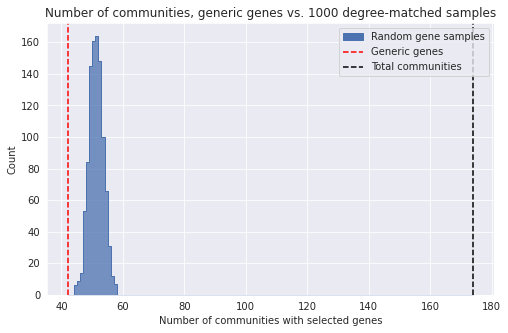

In [13]:
n_generic_groups = nonzero_counts_df.iloc[0, 0]
n_total_groups = len(labels_df.label.unique())

sns.set({"figure.figsize": (8, 5)})

sns.histplot(
    nonzero_counts_df.iloc[0, 1:].values,
    element="step",
    bins=np.arange(n_generic_groups, n_total_groups + 1),
)
line1 = plt.gca().axvline(x=n_generic_groups, linestyle="--", color="red")
line2 = plt.gca().axvline(x=n_total_groups, linestyle="--", color="black")
plt.xlabel("Number of communities with selected genes")
plt.legend(
    handles=[mpatches.Patch(color=sns.color_palette()[0]), line1, line2],
    labels=["Random gene samples", "Generic genes", "Total communities"],
    loc="upper right",
)
plt.title(
    "Number of communities, generic genes vs. {} degree-matched samples".format(
        NUM_NODE_SAMPLES
    )
)

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


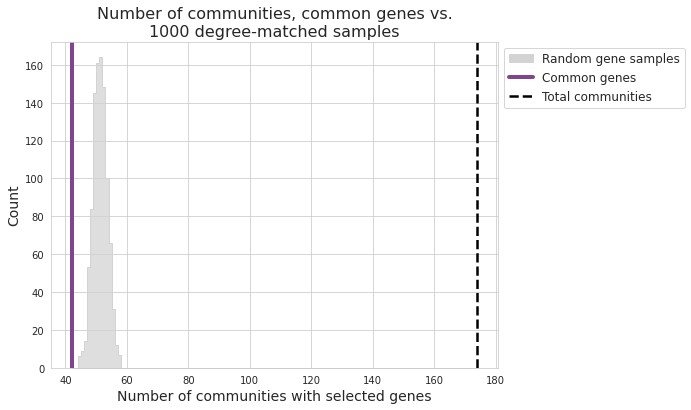

In [14]:
# Format figure for manuscript
sns.set({"figure.figsize": (8, 6)})
sns.set_style("whitegrid")

communities_fig = sns.histplot(
    nonzero_counts_df.iloc[0, 1:].values,
    element="step",
    bins=np.arange(n_generic_groups, n_total_groups + 1),
    palette="lightgrey",
    color="lightgrey",
)

line1 = plt.gca().axvline(
    x=n_generic_groups, linestyle="-", linewidth=4, color="#81448e"
)
line2 = plt.gca().axvline(
    x=n_total_groups, linestyle="--", linewidth=2.5, color="black"
)

communities_fig.set_xlabel(
    "Number of communities with selected genes", fontsize=14, fontname="Verdana"
)
communities_fig.set_ylabel("Count", fontsize=14, fontname="Verdana")

font = font_manager.FontProperties(family="Verdana", style="normal", size=12)

communities_fig.legend(
    handles=[mpatches.Patch(color="lightgrey"), line1, line2],
    labels=["Random gene samples", "Common genes", "Total communities"],
    bbox_to_anchor=(1, 1),
    loc="upper left",
    prop=font,
)
communities_fig.set_title(
    textwrap.fill(
        "Number of communities, common genes vs. {} degree-matched samples".format(
            NUM_NODE_SAMPLES
        ),
        width=40,
    ),
    fontsize=16,
    fontname="Verdana",
)

# Save
communities_fig.figure.savefig(
    "communities_fig.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

These results do not differ substantially from the planted partition results, suggesting that our conclusions are not sensitive to the choice of community detection algorithm.